# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 49

**Author 1 (sciper):** Mariane Brodier (250488)  
**Author 2 (sciper):** Lucas Bost (270139)   
**Author 3 (sciper):** Nicolas Delamaide (271789)

**Release date:** 23.04.2021  
**Due date:** 07.05.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

In [3]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
#Create the sets
sets_names=["a","b","c"]
sets=[a,b,c]

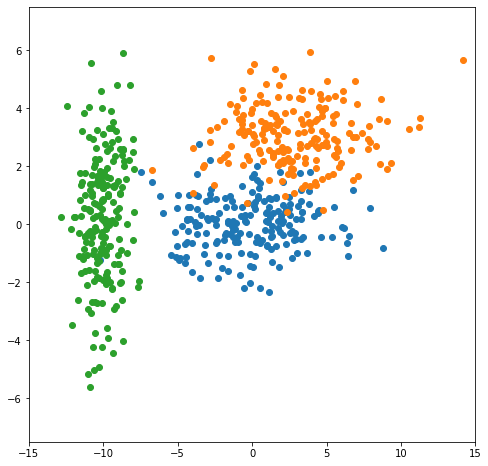

In [5]:
#Print data for better visualisation
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for data,name in zip(sets,sets_names):
    ax.scatter(data[:,0], data[:,1], label=name)
    plt.ylim(-7.5,7.5)
    plt.xlim(-15,15)

In [6]:
#Find p-value for each direction of each set
for name,data in zip(sets_names,sets):
    k2, p = stats.normaltest(data, axis=0)
    print("p_value, set", name, "in x {:.3f} in y {:.3f}".format(p[0], p[1]))

p_value, set a in x 0.965 in y 0.956
p_value, set b in x 0.065 in y 0.581
p_value, set c in x 0.772 in y 0.665


In this kind of test, the null hypothesis is "The data follow a normal distribution". If the p-value is over 0.05 we fail to reject the null hypothesis. Here since the p-values are all above 0.05, for many of them way above, we can assume that the data follows a normal distribution.

In [7]:
#Find the parameters
#Extract the means
mu_a = np.mean(a, axis=0)
mu_b = np.mean(b, axis=0)
mu_c = np.mean(c, axis=0)

#Compute the covariance matrices
cov_a = np.cov(a.T)
cov_b = np.cov(b.T)
cov_c = np.cov(c.T)

#Print parameters
print("Mean set a:", mu_a)
print("Mean set b:", mu_b)
print("Mean set c:", mu_c)
print("Covariance matrix set a:", cov_a)
print("Covariance matrix set b:", cov_b)
print("Covariance matrix set c:", cov_c)

Mean set a: [-0.21000115  0.03048009]
Mean set b: [2.8018991 3.0535643]
Mean set c: [-10.05748461   0.22582978]
Covariance matrix set a: [[10.02769733  0.13162336]
 [ 0.13162336  0.83932673]]
Covariance matrix set b: [[10.17034812  0.18023771]
 [ 0.18023771  1.0840038 ]]
Covariance matrix set c: [[0.97013029 0.23458112]
 [0.23458112 4.69756273]]


We see that the covariance matrices of sets a and b are really close. On the other hand, the  covariance matrix of set c has a way higher y variance and way lower x variance. This should lead to different separation between sets a and b and between these two sets with set c.

The discriminant function is:
$$g_i(x) = -\frac{1}{2}x^T\Sigma_i^{-1}x + \frac{1}{2}x^T\Sigma_i^{-1}\mu_i - \frac{1}{2}\mu_i^T\Sigma_i^{-1}\mu_i + \frac{1}{2}\mu_i^T\Sigma_i^{-1}x + \ln{(\frac{1}{\sqrt{2\pi|\Sigma_i^{-1}|}})}$$

In [8]:
#Get the inverse of covariance matrices
cov_inv_a = np.linalg.inv(cov_a)
cov_inv_b = np.linalg.inv(cov_b)
cov_inv_c = np.linalg.inv(cov_c)
#Define the discriminant function
def gi(x, mu, cov_inv):
    value = -0.5*np.dot(np.dot(x, cov_inv), x) + 0.5*np.dot(np.dot(x, cov_inv), mu) - 0.5*np.dot(np.dot(mu, cov_inv), mu) + 0.5*np.dot(np.dot(mu, cov_inv), x) + np.log(1/(np.sqrt(2*np.pi)*np.sqrt(np.linalg.norm(cov_inv))))
    return value

Now we will calculate the result of the discriminant function for each points in the boundaries regions. We will observe the difference of the results between class a and b, between class a and c and between class b and c. If the difference is low then the point is added to the separation curve.

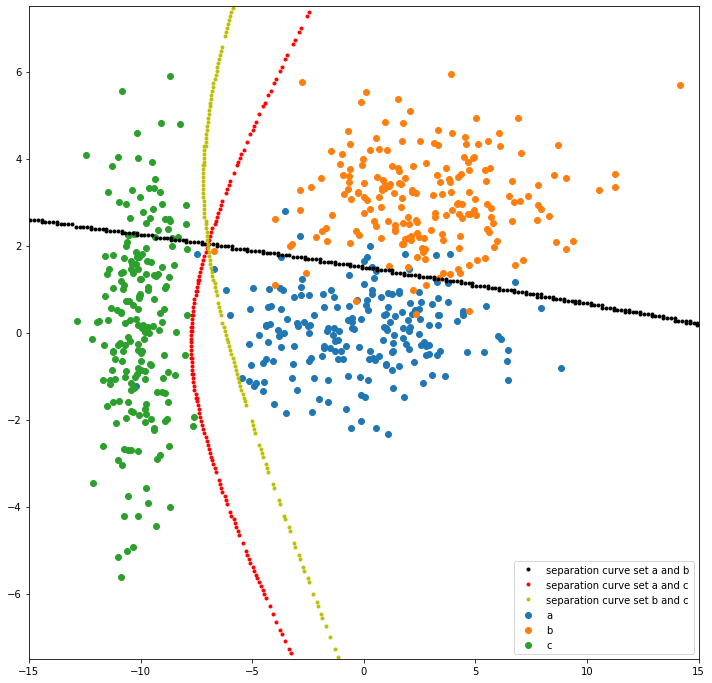

In [9]:
#Create the limit
epsilon = 10e-2

#Create empty curves
sep_ab = []
sep_ac = []
sep_bc = []

for m in np.linspace(-17, 17, 200):
    for n in np.linspace(-5, 5, 200):
        x = np.array([m,n])
        g_a = gi(x, mu_a, cov_inv_a)
        g_b = gi(x, mu_b, cov_inv_b)
        diff_ab = g_a - g_b
        if np.abs(diff_ab) < epsilon:
            sep_ab.append([m,n])
for m in np.linspace(-10, 0, 200):
    for n in np.linspace(-9, 9, 200):
        x = np.array([m,n])
        g_a = gi(x, mu_a, cov_inv_a)
        g_b = gi(x, mu_b, cov_inv_b)
        g_c = gi(x, mu_c, cov_inv_c)
        diff_ac = g_a - g_c
        diff_bc = g_b - g_c
        if np.abs(diff_ac) < epsilon:
            sep_ac.append([m,n])
        if np.abs(diff_bc) < epsilon:
            sep_bc.append([m,n])
            

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
for data,name in zip(sets,sets_names):
    ax.scatter(data[:,0], data[:,1], label=name)
ax.plot([curve[0] for curve in sep_ab],[curve[1] for curve in sep_ab] , 'k.', label='separation curve set a and b')
ax.plot([curve[0] for curve in sep_ac],[curve[1] for curve in sep_ac] , 'r.', label='separation curve set a and c')
ax.plot([curve[0] for curve in sep_bc],[curve[1] for curve in sep_bc] , 'y.', label='separation curve set b and c')
ax.legend()
plt.ylim(-7.5,7.5)
plt.xlim(-15,15)
plt.show()

We see that the separation is quite good. There are some outliers in classes a and b but globally the result is satisfying. Since the 2 covariance matrices of class a and b are very similar, the separation curve looks very much like a line. On the other hand, the separation curves of class a and c and b and c are nonlinear. This is because the variance in y is much larger for class c.

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

The Mahalanobis distance is given by:

$$d_m = \sqrt{(x-\mu_i)^{T}\Sigma_i^{-1}(x-\mu_i)}$$

In [11]:
#Define the Mahalanobis distance
def dm(x, mu, cov_inv):
    mahalanobis_distance = np.sqrt(np.dot(np.dot((x-mu), cov_inv), (x-mu)))
    return mahalanobis_distance

We generate 50 random points and for each point, we calculate its Mahalanobis distance regarding sets a and b. The point is affected to the set for which the Mahalanobis distance is the smallest.

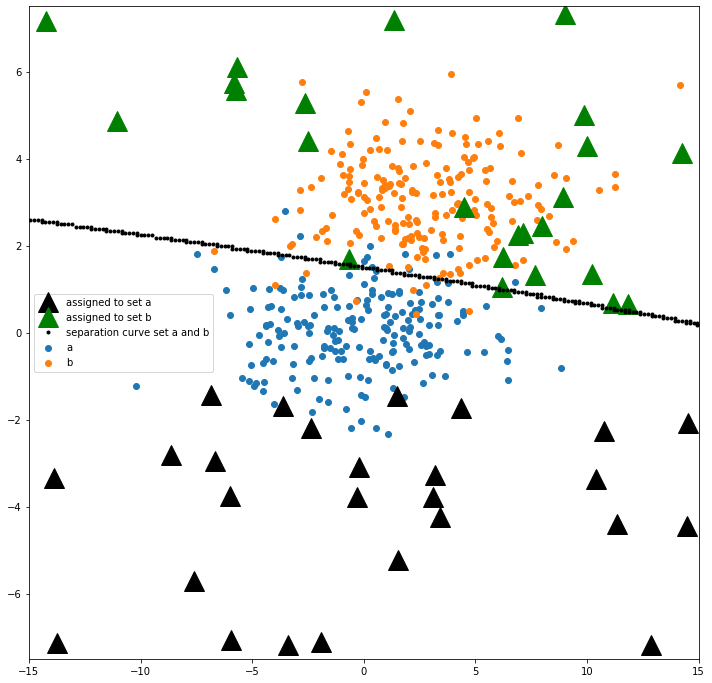

In [12]:
#import for creating random points
from random import random

#Create empty sets of points
a_points = []
b_points = []

for _ in range(50):
    #Random x position in [-15, 15]
    x_pos = -15 + (random() * (30))
    #Random y position in [-7.5, 7.5]
    y_pos = -7.5 + (random() * (15))
    #Create point x
    x = np.array([x_pos, y_pos])
    #Compute Mahalanobis distances
    dm_a = dm(x, mu_a, cov_inv_a)
    dm_b = dm(x, mu_b, cov_inv_b)
    if dm_a < dm_b:
        a_points.append(x)
    else:
        b_points.append(x)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
for data,name in zip([a,b], ["a","b"]):
    ax.scatter(data[:,0], data[:,1], label=name)
ax.plot([points[0] for points in a_points], [points[1] for points in a_points] ,'k^', markersize=20, label='assigned to set a')
ax.plot([points[0] for points in b_points], [points[1] for points in b_points] ,'g^', markersize=20, label='assigned to set b')
ax.plot([curve[0] for curve in sep_ab],[curve[1] for curve in sep_ab] , 'k.', label='separation curve set a and b')
plt.legend()
plt.ylim(-7.5,7.5)
plt.xlim(-15,15)
plt.show()

We can see that the classification obtained using Mahalanobis distance is right (without considering set c). Indeed the points under the separation curve are assigned to the set a and the points above the separation curve are assigned to set b.

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [13]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [14]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

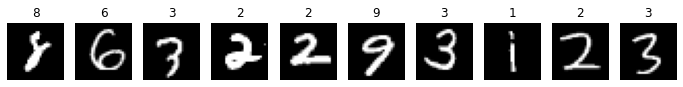

In [15]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [16]:
train_images_flattened = train_images.reshape(train_images.shape[0], -1) # Reshape to a 784 - dimensional image
test_images_flattened = test_images.reshape(test_images.shape[0], -1) # Reshape to a 784 - dimensional image

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # to scale the values of the pixels
scaler.fit(train_images_flattened)  

train_images_scaled = scaler.transform(train_images_flattened)  # Scale train_images
test_images_scaled = scaler.transform(test_images_flattened) # Scale test_images

hidden_units = 100

clf = MLPClassifier(hidden_layer_sizes = (hidden_units,), random_state=42).fit(train_images_scaled, train_labels)

clf.score(test_images_scaled, test_labels)

0.9773

We see that we get a mean accuracy of 97% with our MLP, it's very good ! Let's look at some of the model predictions.

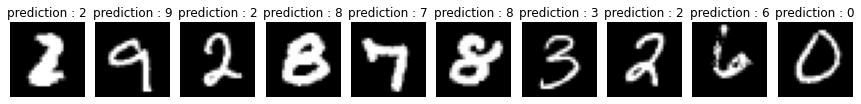

In [18]:
predictions = clf.predict(test_images_scaled)

plt_ind = prng.randint(low=0, high=test_images.shape[0], size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, test_images[plt_ind], predictions[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title("prediction : " + str(lb))

fig.tight_layout()

We can look at some of the mislabelled images :

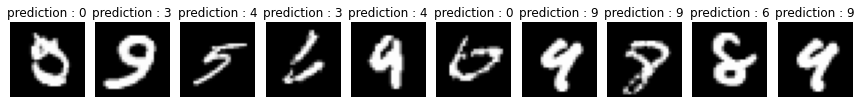

In [19]:
mask = (predictions - test_labels != 0) # mislabelled indexes

mislabelled = predictions[mask] # get predictions that are wrong
images_mislabelled = test_images[mask] # get mislabelled images

plt_ind = prng.randint(low=0, high=images_mislabelled.shape[0], size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, images_mislabelled[plt_ind], mislabelled[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title("prediction : " + str(lb))

fig.tight_layout()